# Geopandas recipes for feature data
various sources

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
import matplotlib.pyplot as plt

# Creating a geodataframe from point lat-lon features
This example is taken from the geopandas documentation here: https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [2]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

In [3]:
df

,City,Country,Latitude,Longitude
0,Buenos Aires,Argentina,-34.58,-58.66
1,Brasilia,Brazil,-15.78,-47.91
2,Santiago,Chile,-33.45,-70.66
3,Bogota,Colombia,4.60,-74.08
4,Caracas,Venezuela,10.48,-66.86


In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [5]:
gdf

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

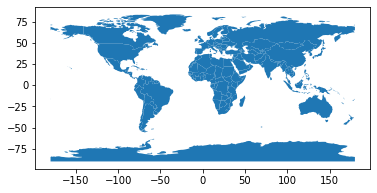

In [7]:
world.plot()

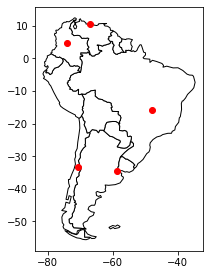

In [8]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
world[world.continent == 'South America'].plot(
    color='white', edgecolor='black', ax=ax)
gdf.plot(ax=ax, color='red')
plt.show()

# Create a regular grid of polygons
Example adapted from here: https://gis.stackexchange.com/questions/269243/creating-polygon-grid-using-geopandas

In [9]:
xmin, ymin, xmax, ymax = -180, -90, 180, 90
length = 10
width = 10
cols = np.arange(xmin, xmax, width)
rows = np.arange(ymin, ymax, length)

In [10]:
polygons = [Polygon([(x,y), 
                     (x+width, y),
                     (x+width, y+length),
                     (x, y+length)]) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry':polygons})

In [11]:
grid = grid.set_crs(epsg=4326)

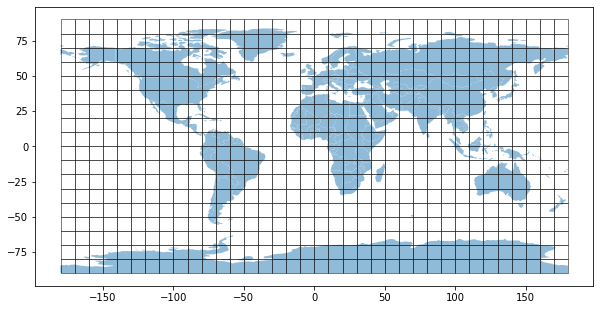

In [12]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
world.plot(ax=ax)
grid.plot(color='white', edgecolor='black', ax=ax, alpha=0.5)
plt.show()

# Clipping polygons using other polygons

In [13]:
sa = world[world.continent == 'South America']
sa_grid = gpd.clip(grid, sa)

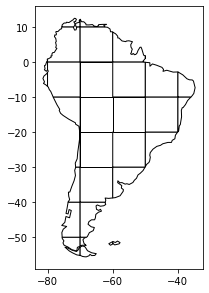

In [14]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
sa_grid.plot(color='white', edgecolor='black', ax=ax)
plt.show()

# Intersection

Note that `overlay` is only for geometries of the same type. See the documentation:

https://geopandas.org/reference/geopandas.overlay.html

In [15]:
sa = world[world.continent == 'South America']
sa_grid_int = gpd.overlay(grid, sa, how='intersection')

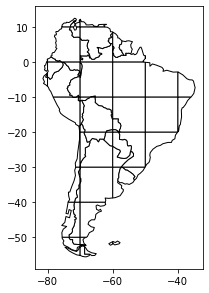

In [16]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
sa_grid_int.plot(color='white', edgecolor='black', ax=ax)
plt.show()

to make this and the following examples a little more visual, we will use two standard shapes

In [17]:
square = gpd.GeoDataFrame({'geometry': Polygon([(0, 0),
                                                (1, 0),
                                                (1, 1),
                                                (0, 1)])},
                         index=[0]).set_crs(epsg=4326)
center = pd.DataFrame({'lat': [1], 'lon': [0.5]})
centroid = gpd.GeoDataFrame(center,
                            geometry=gpd.points_from_xy(center.lon,
                                                        center.lat))
circle = gpd.GeoDataFrame({'geometry': centroid.buffer(0.4)}).set_crs(epsg=4326)

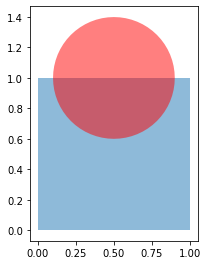

In [18]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
square.plot(ax=ax, alpha=0.5)
circle.plot(ax=ax, alpha=0.5, color='r')
plt.show()

<AxesSubplot:>

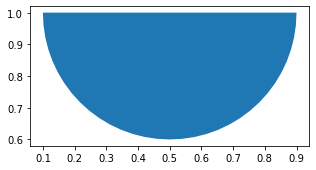

In [19]:
circ_sqr_intersection = gpd.overlay(square, circle, how='intersection')
circ_sqr_intersection.plot(figsize=(5,3))

# Union

<AxesSubplot:>

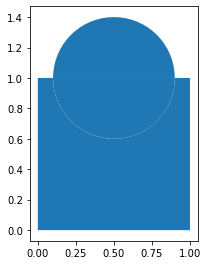

In [20]:
circ_sqr_union = gpd.overlay(square, circle, how='union')
circ_sqr_union.plot(figsize=(3, 5))

Note the other options for `overlay()` currently implemented: `identity`, `symmetric_difference` or `difference`.

# Merging data

The following three examples are from here: https://geopandas.org/docs/user_guide/mergingdata.html

In [21]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

For the attribute join

In [22]:
# For attribute join
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]

In [23]:
# For spatial join
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})

## Append

### appending a GeoSeries

In [24]:
joined = world.geometry.append(cities.geometry)

<AxesSubplot:>

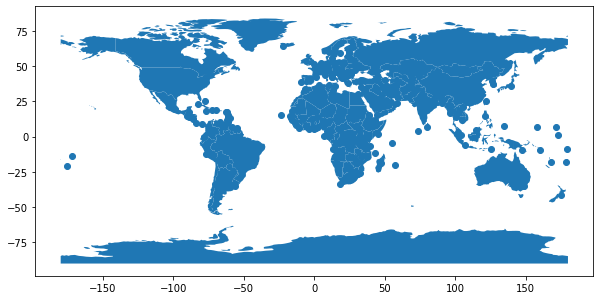

In [25]:
joined.plot(figsize=(10, 6))

### appending a GeoDataFrame

In [26]:
europe = world[(world.continent == 'Europe') & (world['name'] != 'Russia')]
africa = world[world.continent == 'Africa']
eurafrica = europe.append(africa)

<AxesSubplot:>

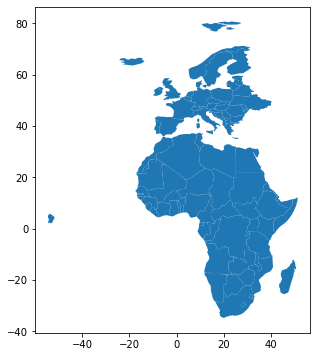

In [27]:
eurafrica.plot(figsize=(10, 6))

## attribute joins

In [28]:
country_shapes.head()

,geometry,iso_a3
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA


In [29]:
country_names.head()

,name,iso_a3
0,Fiji,FJI
1,Tanzania,TZA
2,W. Sahara,ESH
3,Canada,CAN
4,United States of America,USA


In [30]:
country_shapes_names = country_shapes.merge(country_names, on='iso_a3')

In [31]:
country_shapes_names.head()

,geometry,iso_a3,name
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,Fiji
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,Tanzania
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,W. Sahara
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,Canada
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,United States of America


In [32]:
country_names_cheaut = country_names[country_names.iso_a3.isin(['CHE', 'AUT'])]
country_shapes_names_cheaut = country_shapes.merge(country_names_cheaut, on='iso_a3', how='inner')

<AxesSubplot:>

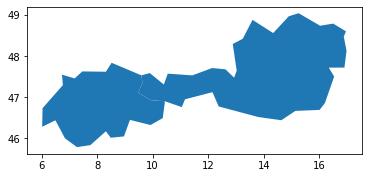

In [33]:
country_shapes_names_cheaut.plot()

In [34]:
country_shapes_names_cheaut = country_shapes.merge(country_names_cheaut, on='iso_a3', how='outer')

<AxesSubplot:>

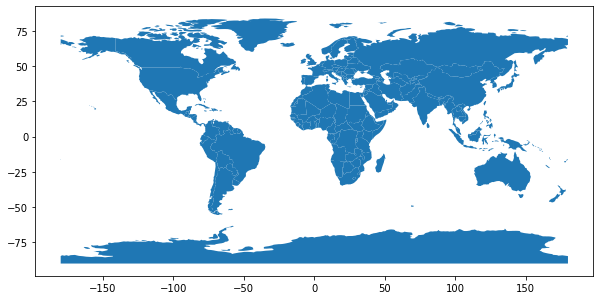

In [35]:
country_shapes_names_cheaut.plot(figsize=(10, 6))

In [36]:
country_shapes_names_cheaut.head()

,geometry,iso_a3,name
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,NaN
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,NaN
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,NaN
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,NaN
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,NaN


## spatial joins

In [37]:
countries.head()

,geometry,country
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",W. Sahara
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America


In [38]:
cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


<AxesSubplot:>

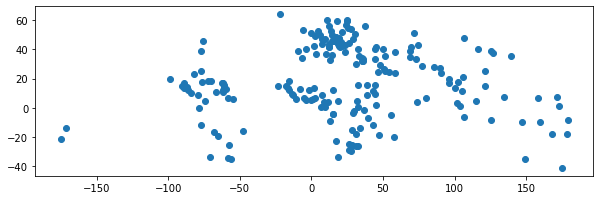

In [39]:
cities.plot(figsize=(10, 6))

In [40]:
cities_with_country = gpd.sjoin(cities, countries, how="inner", op='intersects')

<AxesSubplot:>

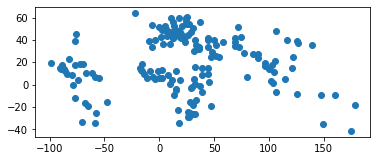

In [41]:
cities_with_country.plot()

In [42]:
cities_with_country.head()

,name,geometry,index_right,country
0,Vatican City,POINT (12.45339 41.90328),141,Italy
1,San Marino,POINT (12.44177 43.93610),141,Italy
192,Rome,POINT (12.48131 41.89790),141,Italy
2,Vaduz,POINT (9.51667 47.13372),114,Austria
184,Vienna,POINT (16.36469 48.20196),114,Austria


Note that `sjoin` supports different types of joins based on spatial relationships:

- `intersects`
- `contains`
- `within`
- `touches`
- `crosses`
- `overlaps`

For more, see the `geopandas` documentation:

https://geopandas.org/docs/user_guide/mergingdata.html